In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, recall_score,confusion_matrix, precision_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler
from pdpbox import pdp, get_dataset, info_plots
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer
import seaborn as sns
%matplotlib inline

In [313]:
pd.set_option('display.max_rows', None)

***CUSTOM CLASSES***

In [314]:
class CustomEDA:     
    """Custom Exploratory Data Analysis Class"""    
    
    def fn_nulls_count(self, df):
        """Function to count the null values and their percentages in each column."""
        # Nulls counts in each column.
        nulls_counts = df.isnull().sum()
        # Convert above series into dataframe.
        nulls_counts_df = nulls_counts.to_frame(name = 'nulls_count')
        # Add a new column - to get the null counts percentage to the total rows.
        nulls_counts_df['nulls_percentage'] = round(100 * nulls_counts_df['nulls_count']/df.shape[0], 2)
        # Return the null counts dataframe.
        return nulls_counts_df
    
    def fn_plot_residuals(self, df):
        """Function to plot residuals in data."""
        # retrieve data as numpy array
        values = df.values
        print(values.shape)
        # create a subplot for each time series
        plt.figure(figsize=(16, 16))
        for i in range(values.shape[1]):
            plt.subplot(values.shape[1], 1, i+1)
            plt.plot(values[:, i])
        plt.show()
    
    
    def fn_compute_outliers(self, df):
        """Function to check for outliers in data."""
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        cleaned_eeg_df = df[~((df < (Q1 - 1.5 * IQR)) |
                                  (df > (Q3 + 1.5 * IQR)))\
                                .any(axis=1)]
        print(cleaned_eeg_df.shape)
    
    
    def fn_plot_correlation(self, df):
        """Function to plot the correlation in data."""
        plt.figure(figsize=(20,20))
        sns.heatmap(df.corr(), annot=True)
        plt.xticks(rotation=45)
        plt.show()
    
    def fn_check_and_drop_duplicates(self, df):
        """Function to check and drop duplicates in data."""
        duplicate = df[df.duplicated()]  
        print("Duplicate Rows :")  
        #Print the resultant Dataframe 
        duplicate 
        df_duplicates_removed = pd.DataFrame.drop_duplicates(df)
        print(df_duplicates_removed)
        return df_duplicates_removed

    def fn_compute_metrics(self, model, x_train, x_test, y_train, y_test, iter_no, model_name):
        """Function to compute metrics after the model has been built. 
           Takes model_name as in input parameter to store results of various models 
           Uses a dataframe metric_data to store the results of various runs across various ML models
        """
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        print(model.score(x_train, y_train))
        print(model.score(x_test, y_test))
        print("\n")
        confusion_matrix_train = confusion_matrix(y_true=y_train, y_pred = train_pred)
        confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)
        print(confusion_matrix_train)   
        print(confusion_matrix_test)   

        f1 = f1_score(y_train,train_pred)
        recall = recall_score(y_train,train_pred)
        accuracy = accuracy_score(y_train,train_pred)
        prec = precision_score(y_train, train_pred)
        metric_data.loc[metric_data.shape[0]] = [iter_no,model_name,'Train',accuracy,f1,recall, prec] 

        f1_test = f1_score(y_test,test_pred)
        rc_test = recall_score(y_test,test_pred)
        ac_test = accuracy_score(y_test,test_pred)
        prec_test = precision_score(y_test, test_pred)
        metric_data.loc[metric_data.shape[0]] = [iter_no,model_name,'Test',ac_test,f1_test,rc_test, prec_test] 
        print(classification_report(y_train,train_pred))
    
    def fn_set_up_metric_data(self):
        """Intialiazes the metric_data to store result of various runs"""
        metric_data = pd.DataFrame(columns = ['Iteration No', 'Model Name','Method Type','Accuracy Score','F1 score','Recall Score', 'Precision Score'])
        return metric_data
    
    def fn_fetch_col_based_ontype(self, df, *args):
        """Function to return column based on column type"""
        return df.select_dtypes(include=args).columns.tolist()
    
    def fn_get_data_information(self, df):
        """Function to fetch data-frame information"""
        print(f'Shape of dataframe is {df.shape}')
        print('*************************************************************')
        print("DataFrame information")
        print(df.info())
        print('************************************************************')
        print("DataFrame Summary")
        print(df.describe())
        
    def fn_plot_pairplots(self, df, targetCol):
        for i in range(0, len(df.columns), 5):
                sns.pairplot(data=df,
                x_vars=df.columns[i:i+5],
                y_vars=[targetCol])
                
    def fn_plot_regplot(self, df, features_to_analyse, targetCol):
        fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))
        for i, ax in enumerate(fig.axes):
            if i < len(features_to_analyse) - 1:
                sns.regplot(x=features_to_analyse[i],y=targetCol, data=df[features_to_analyse], ax=ax)
                
    def fn_plot_countplot(self, df_not_num):
        fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(12, 30))
        for i, ax in enumerate(fig.axes):
            if i < len(df_not_num.columns):
                ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
                sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)
        fig.tight_layout() 
    
    def fn_plot_histplot(self, df_num):
        df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
        
    def fn_nulls_plot(self,df):
        sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [315]:
class PrepModel:  
    
    """Custom Class for data preparation before model building""" 
    
    def fn_split_train_test(self, X, y):
        """Train-Test split of the data""" 
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, test_size=0.20, random_state=42)
        print(f'Shape of X_Train is {X_train.shape}')
        print('*************************************************************')
        print(f'Shape of y_train is {y_train.shape}')
        print('*************************************************************')
        print(f'Shape of X_test is {X_test.shape}')
        print('*************************************************************')
        print(f'Shape of y_test is {y_test.shape}')
        return X_train, X_test, y_train, y_test
    
    def fn_init_pipeline(self, numerical_columns, categorical_columns):
        """Initialize the pipeline for the data""" 
        # Preprocessing for numerical data
        num_transformer = Pipeline(steps=[            
            ('num_scaler', StandardScaler())])
        
        # Preprocessing for categorical data
        categorical_transformer = Pipeline(steps=[       
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
        
       # Bundle preprocessing for numerical and categorical data
        preprocessor = ColumnTransformer(
        transformers=[
            ('num_trf', num_transformer, numerical_columns),
            ('cat_trf', categorical_transformer, categorical_columns)
        ])
        
        return preprocessor              

***EXPLORATORY DATA ANALYSIS***

In [316]:
data = pd.read_csv("./datasets/train_data-1599717478076.csv")

In [317]:
data.shape

(76529, 11)

In [318]:
data.head()

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud
0,144703125000,17539344,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-5.0,2016-11-15 19:16:12+00:00,2,0
1,77406814453032,24710841,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,100.0,2017-01-11 09:25:33+00:00,2,0
2,308929485482801,24265476,e_wallet_payments,78890,cat_2,IND_INR,other_pcs,50.0,2016-12-07 07:58:09+00:00,2,0
3,665270027747073,10240000,other_debit_cards,102557,cat_3,IND_INR,other_pcs,1000.0,2017-01-11 16:15:44+00:00,2,0
4,38276160171101,5880625,other_debit_cards,118335,cat_1,IND_INR,other_pcs,200.0,2016-11-16 17:04:42+00:00,2,0


In [319]:
data.tail()

,transaction_number,user_id,payment_method,partner_id,partner_category,country,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud
76524,179759462245453,19686969,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-100.0,2016-11-30 13:40:45+00:00,2,0
76525,2693567760244353,11662225,visa_master_debit_cards,118335,cat_1,IND_INR,other_pcs,200.0,2017-01-08 08:35:31+00:00,2,0
76526,119750257089000,374544,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-3.5,2016-12-26 21:47:08+00:00,2,0
76527,1949798765017089,1687401,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-20.0,2016-12-11 13:44:06+00:00,2,0
76528,1051344513778987,6754801,sbi_atm_cum_debit_card,47334,cat_1,IND_INR,android_devices,-100.0,2017-01-11 19:08:18+00:00,2,0


In [320]:
data.nunique()

transaction_number          76529
user_id                      3594
payment_method                  6
partner_id                     23
partner_category                9
country                         1
device_type                     4
money_transacted             1454
transaction_initiation      75811
partner_pricing_category        4
is_fraud                        2
dtype: int64

In [321]:
data.dtypes

transaction_number            int64
user_id                       int64
payment_method               object
partner_id                    int64
partner_category             object
country                      object
device_type                  object
money_transacted            float64
transaction_initiation       object
partner_pricing_category      int64
is_fraud                      int64
dtype: object

In [322]:
#Call the custom class for doing EDA
eda = CustomEDA()

In [323]:
eda.fn_get_data_information(data)

Shape of dataframe is (76529, 11)
*************************************************************
DataFrame information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76529 entries, 0 to 76528
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_number        76529 non-null  int64  
 1   user_id                   76529 non-null  int64  
 2   payment_method            76529 non-null  object 
 3   partner_id                76529 non-null  int64  
 4   partner_category          76529 non-null  object 
 5   country                   76529 non-null  object 
 6   device_type               76529 non-null  object 
 7   money_transacted          76529 non-null  float64
 8   transaction_initiation    76529 non-null  object 
 9   partner_pricing_category  76529 non-null  int64  
 10  is_fraud                  76529 non-null  int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 6.4+

In [324]:
data.columns

Index(['transaction_number', 'user_id', 'payment_method', 'partner_id',
       'partner_category', 'country', 'device_type', 'money_transacted',
       'transaction_initiation', 'partner_pricing_category', 'is_fraud'],
      dtype='object')

In [325]:
data.drop(['country','transaction_number'], axis=1, inplace=True)

In [326]:
data.columns

Index(['user_id', 'payment_method', 'partner_id', 'partner_category',
       'device_type', 'money_transacted', 'transaction_initiation',
       'partner_pricing_category', 'is_fraud'],
      dtype='object')

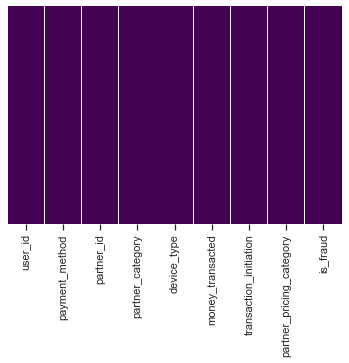

In [327]:
eda.fn_nulls_plot(data)

In [328]:
eda.fn_nulls_count(data)

,nulls_count,nulls_percentage
user_id,0,0.0
payment_method,0,0.0
partner_id,0,0.0
partner_category,0,0.0
device_type,0,0.0
money_transacted,0,0.0
transaction_initiation,0,0.0
partner_pricing_category,0,0.0
is_fraud,0,0.0


In [329]:
data.isna().sum()

user_id                     0
payment_method              0
partner_id                  0
partner_category            0
device_type                 0
money_transacted            0
transaction_initiation      0
partner_pricing_category    0
is_fraud                    0
dtype: int64

In [330]:
data.head()

,user_id,payment_method,partner_id,partner_category,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud
0,17539344,sbi_atm_cum_debit_card,47334,cat_1,android_devices,-5.0,2016-11-15 19:16:12+00:00,2,0
1,24710841,e_wallet_payments,78890,cat_2,other_pcs,100.0,2017-01-11 09:25:33+00:00,2,0
2,24265476,e_wallet_payments,78890,cat_2,other_pcs,50.0,2016-12-07 07:58:09+00:00,2,0
3,10240000,other_debit_cards,102557,cat_3,other_pcs,1000.0,2017-01-11 16:15:44+00:00,2,0
4,5880625,other_debit_cards,118335,cat_1,other_pcs,200.0,2016-11-16 17:04:42+00:00,2,0


In [331]:
# Convert few columns to categories
col_to_be_converted = ['user_id', 'partner_id', 'partner_pricing_category', 'is_fraud']
data[col_to_be_converted] = data[col_to_be_converted].astype('category')
data.dtypes

user_id                     category
payment_method                object
partner_id                  category
partner_category              object
device_type                   object
money_transacted             float64
transaction_initiation        object
partner_pricing_category    category
is_fraud                    category
dtype: object

In [332]:
# Convert transaction_initiation to date-time
data['transaction_initiation'] = pd.to_datetime(data['transaction_initiation'], format='%Y-%m-%d %H:%M:%S')
data['transaction_initiation'] = data['transaction_initiation'].dt.strftime('%Y-%m-%d %H:%M:%S')
data['transaction_initiation'] = pd.to_datetime(data['transaction_initiation'], format='%Y-%m-%d %H:%M:%S')

In [333]:
# Fetch categorical and numerical columns
cat_cols = eda.fn_fetch_col_based_ontype(data, 'object','category')
num_cols = eda.fn_fetch_col_based_ontype(data, 'float64')



In [334]:
cat_cols

['user_id',
 'payment_method',
 'partner_id',
 'partner_category',
 'device_type',
 'partner_pricing_category',
 'is_fraud']

In [335]:
num_cols

['money_transacted']

In [336]:
data.dtypes

user_id                           category
payment_method                      object
partner_id                        category
partner_category                    object
device_type                         object
money_transacted                   float64
transaction_initiation      datetime64[ns]
partner_pricing_category          category
is_fraud                          category
dtype: object

In [337]:
data.is_fraud.value_counts(normalize=True)

0    0.997988
1    0.002012
Name: is_fraud, dtype: float64

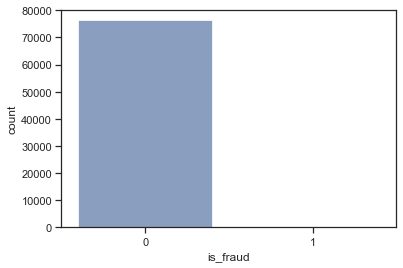

In [338]:
# Check the distribution of Fraud column
sns.countplot(x='is_fraud', alpha=0.7, data=data)

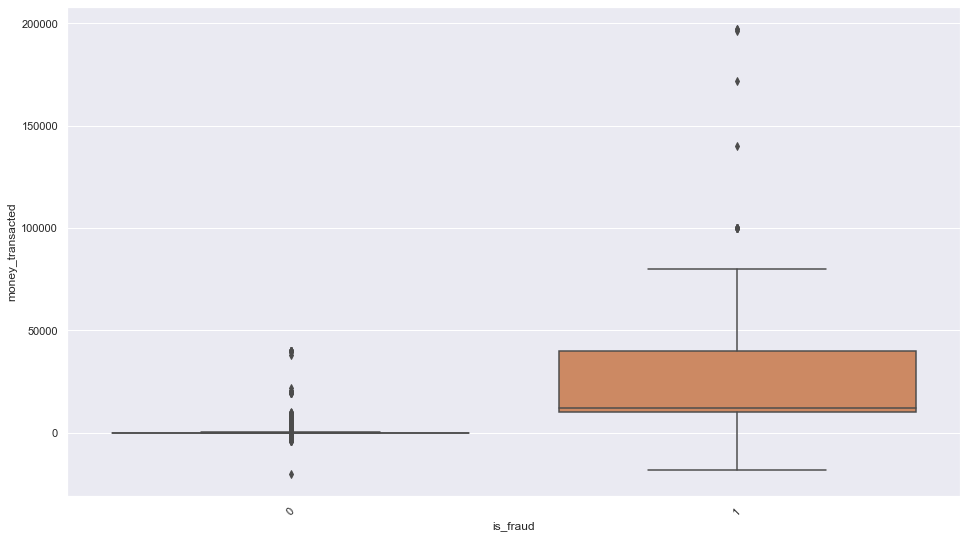

In [339]:
plt.figure(figsize=(16,9))
sns.set(style="darkgrid")
sns.boxplot(x=data.is_fraud, y=data.money_transacted, data=data)
plt.xticks(rotation=45)
plt.show()

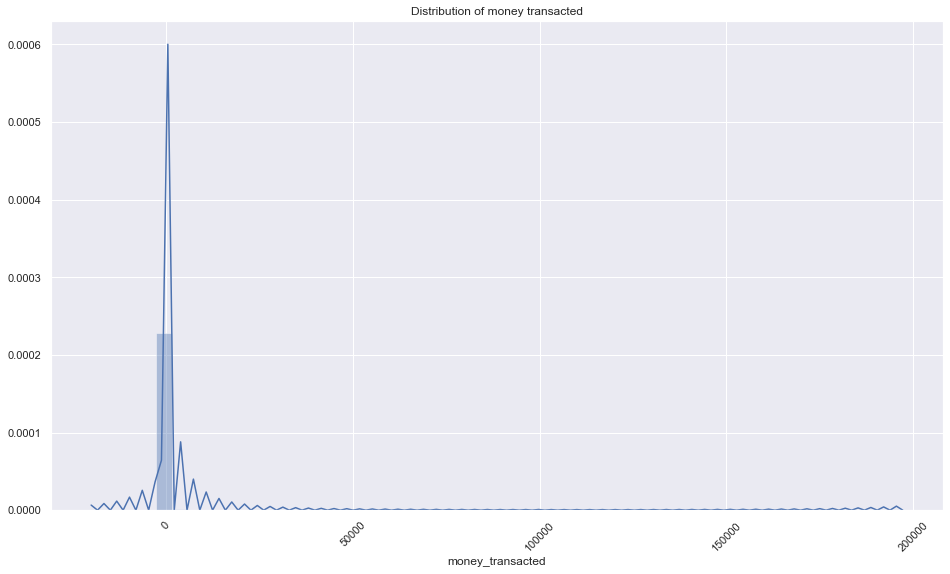

In [340]:
#Plot for distribution of the money transacted.
plt.figure(figsize=(16,9))
sns.set(style="darkgrid")
sns.distplot(data.money_transacted)
plt.xticks(rotation=45)
plt.title('Distribution of money transacted')
plt.show()

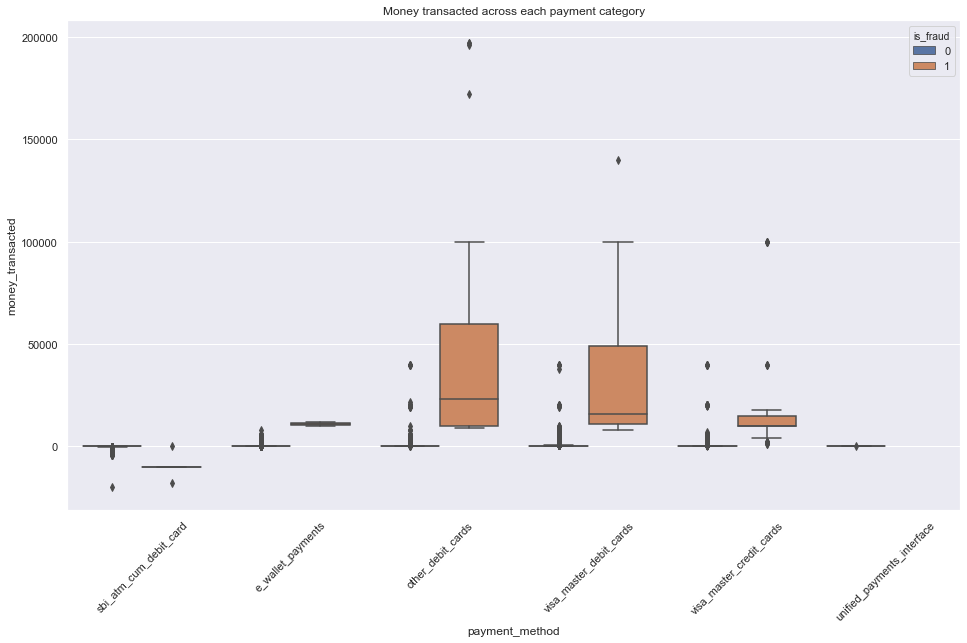

In [341]:
# Plot for money transacted against each payment category grouped by Fraud
plt.figure(figsize=(16,9))
#sns.set(style="ticks")
sns.boxplot(x='payment_method', y='money_transacted', hue='is_fraud', data=data)
plt.title('Money transacted across each payment category')
plt.xticks(rotation=45)
plt.show()

<html><b>From the above plot we can see that Fraud occurs in Payment Categories of <span style="color:red"><i>Other Debit Cards, Visa Master Debit cards and Visa Master Credit cards</i></span></b></html>

In [342]:
data.device_type.value_counts()

other_pcs          45560
android_devices    29662
ios_devices          876
windows_pcs          431
Name: device_type, dtype: int64

<Figure size 1152x1152 with 0 Axes>

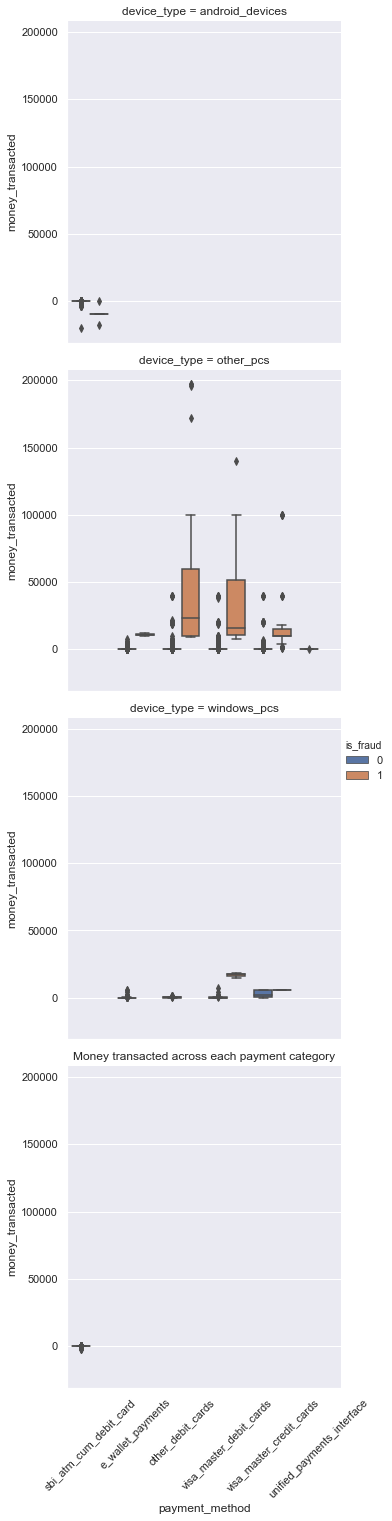

In [343]:
plt.figure(figsize=(16,16))
#sns.set(style="ticks")
sns.catplot(x='payment_method', y='money_transacted', hue='is_fraud', row='device_type', data=data, kind='box')
plt.title('Money transacted across each payment category')
plt.xticks(rotation=45)
plt.show()

<html><b>From the above plot we can see that Fraud occurs in Payment Categories of <span style="color:red"><i>Other Debit Cards, 
Visa Master Debit cards and Visa Master Credit cards</i></span> Also it occurs across device types of 
<span style="color:red"><i> Other Pc's and Windows Pc's</i></span</b></html>

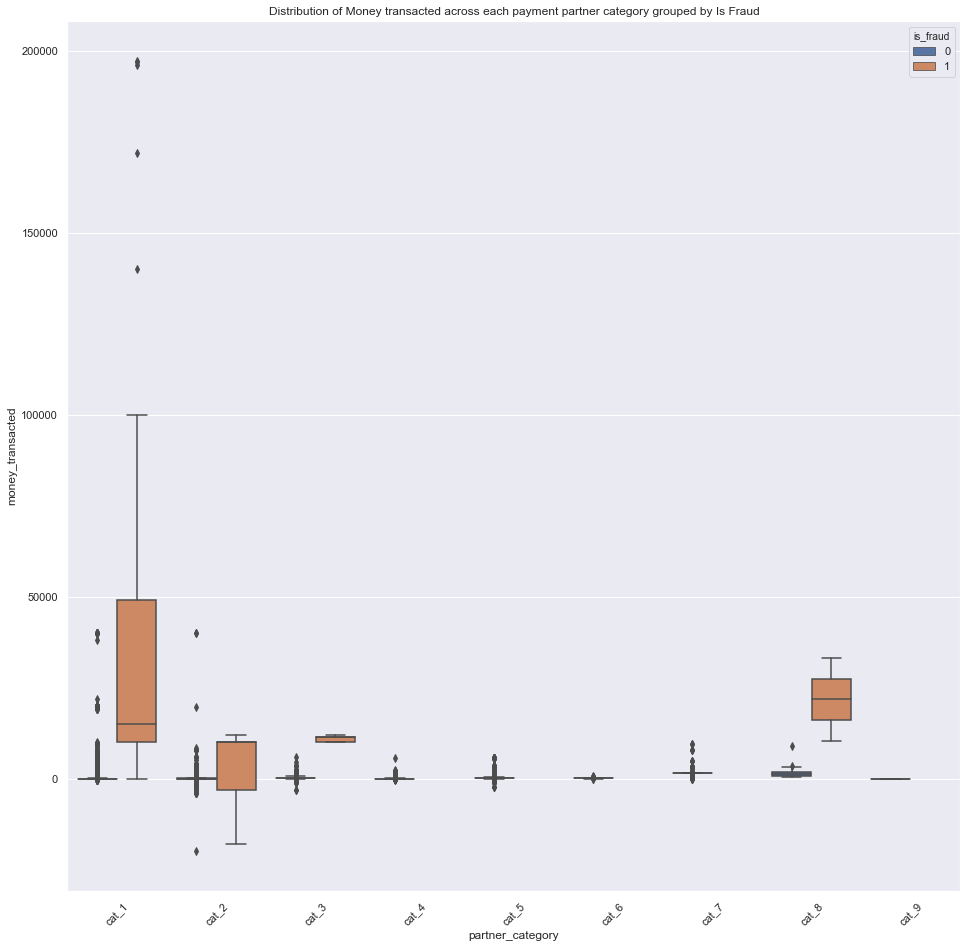

In [344]:
# Distribution of Money transacted across each payment partner category grouped by Is Fraud
plt.figure(figsize=(16,16))
#sns.set(style="ticks")
sns.boxplot(x='partner_category', y='money_transacted', hue='is_fraud', data=data)
plt.title('Distribution of Money transacted across each payment partner category grouped by Is Fraud')
plt.xticks(rotation=45)
plt.show()

<html><b>From the above plot we can see that Fraud occurs in Partner Categories of <span style="color:red"><i>Cat1, 
Cat2, Cat3 and Cat8</i></span></b></html>

In [345]:
data.partner_pricing_category.value_counts()

2    63899
4    10833
1     1497
0      300
Name: partner_pricing_category, dtype: int64

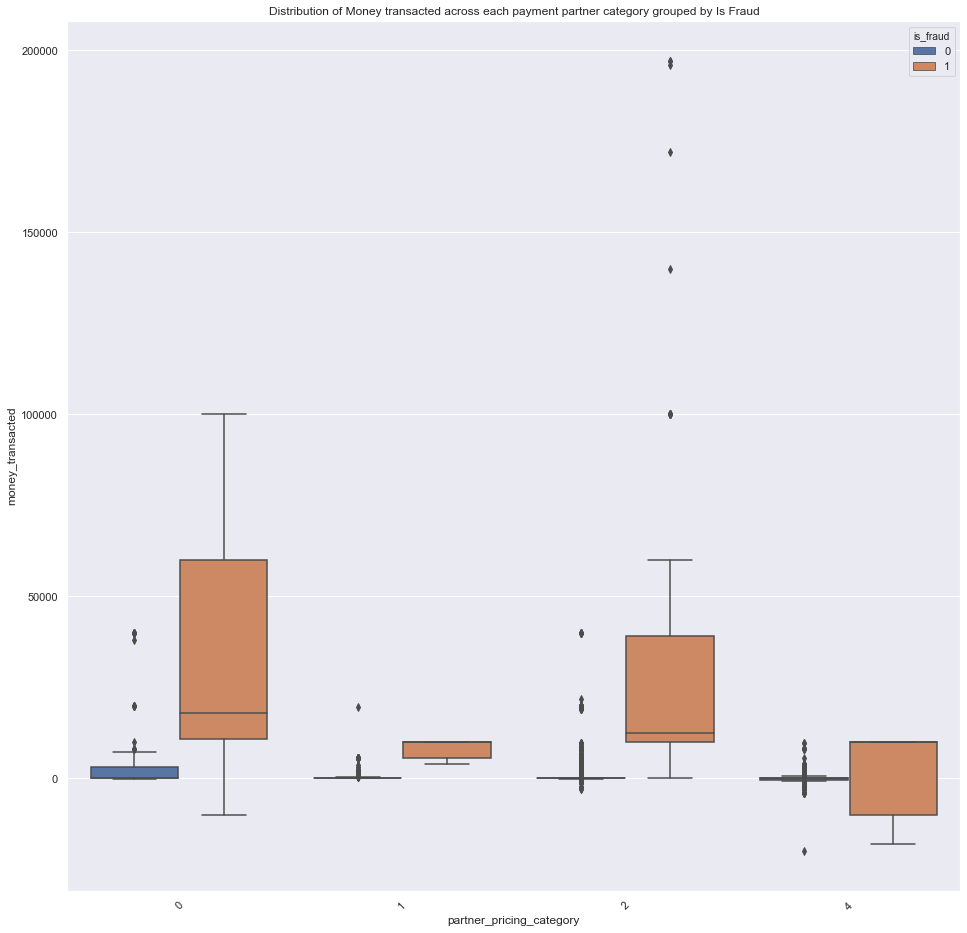

In [346]:
plt.figure(figsize=(16,16))
#sns.set(style="ticks")
sns.boxplot(x='partner_pricing_category', y='money_transacted', hue='is_fraud', data=data)
plt.title('Distribution of Money transacted across each payment partner category grouped by Is Fraud')
plt.xticks(rotation=45)
plt.show()

<html><b><i>The above plot shows distribution of money_transacted across each partnet pricing category. This plot doesnt help us in our analysis much</i></b></html>

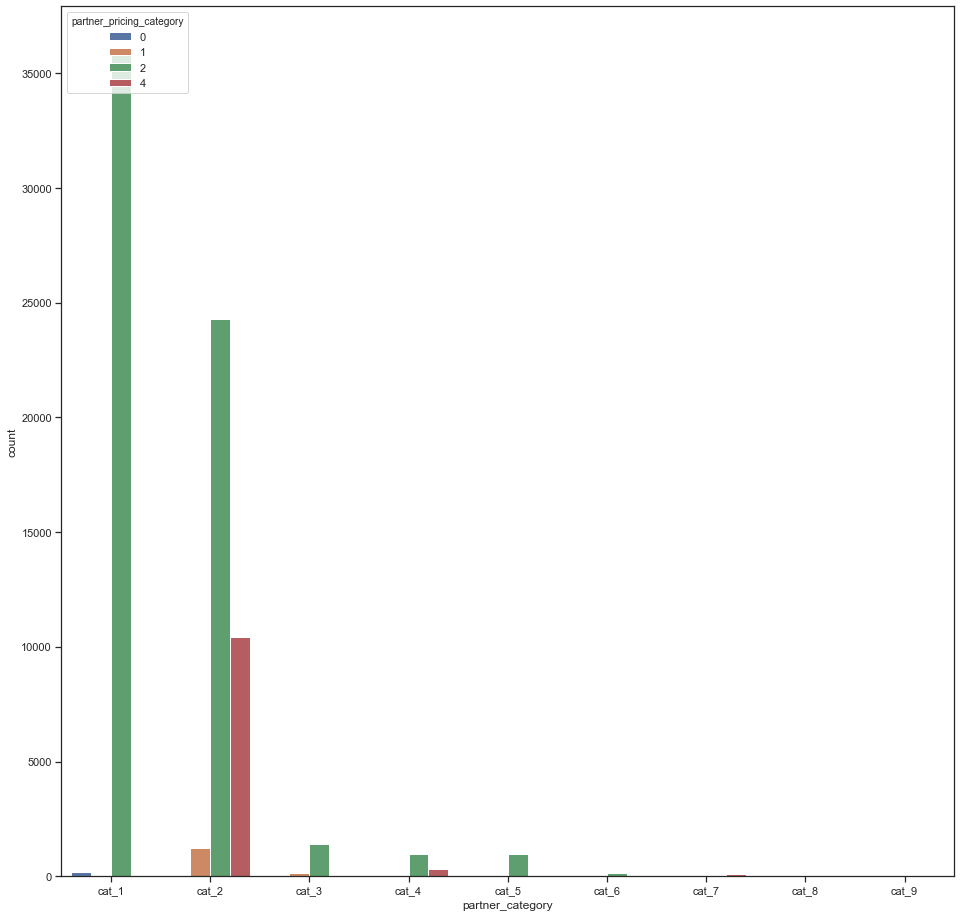

In [84]:
#Relationship between partner category and partner pricing category
plt.figure(figsize=(16,16))
sns.countplot(x='partner_category', hue='partner_pricing_category', data=data)

<html><h2>Feature Engineering</h2></html>

<html><i>Here we have a date-time column. We think the feature is relevant but need some feature engineering on top of it. 
We will sort the data-frame based on the date. We will take the first date and substract it from the remaining dates to find the time elapsed from the start of the transaction. We give a name 'Time' to the column and remove the 'transaction_initiation' column
</i></html>

In [347]:
data_sorted_by_tran_date = data.sort_values('transaction_initiation', ascending=True)

In [348]:
# d1 = data_sorted_by_tran_date.loc[0].transaction_initiation
# d2 = data_sorted_by_tran_date.loc[1].transaction_initiation
# seconds_in_day = 24 * 60 * 60
# difference = d2-d1
# duration_in_s = difference.total_seconds() 
# round(divmod(duration_in_s, 60)[0])

81489

In [349]:
# d1

Timestamp('2016-11-15 19:16:12')

In [350]:
def fn_calc_elapsed_time(d2):
    """Caculate elapsed time"""
    seconds_in_day = 24 * 60 * 60
    d1 = data_sorted_by_tran_date.loc[0].transaction_initiation
    difference = d2-d1
    duration_in_s = difference.total_seconds() 
    return round(divmod(duration_in_s, 60)[0],2)
    

In [351]:
data['Time'] = data['transaction_initiation'].apply(lambda x: fn_calc_elapsed_time(x))

In [352]:
data.head()

,user_id,payment_method,partner_id,partner_category,device_type,money_transacted,transaction_initiation,partner_pricing_category,is_fraud,Time
0,17539344,sbi_atm_cum_debit_card,47334,cat_1,android_devices,-5.0,2016-11-15 19:16:12,2,0,0.0
1,24710841,e_wallet_payments,78890,cat_2,other_pcs,100.0,2017-01-11 09:25:33,2,0,81489.0
2,24265476,e_wallet_payments,78890,cat_2,other_pcs,50.0,2016-12-07 07:58:09,2,0,31001.0
3,10240000,other_debit_cards,102557,cat_3,other_pcs,1000.0,2017-01-11 16:15:44,2,0,81899.0
4,5880625,other_debit_cards,118335,cat_1,other_pcs,200.0,2016-11-16 17:04:42,2,0,1308.0


In [109]:
data.Time.nunique()

43585

In [110]:
data.nunique()

user_id                      3594
payment_method                  6
partner_id                     23
partner_category                9
device_type                     4
money_transacted             1454
transaction_initiation      75811
partner_pricing_category        4
is_fraud                        2
Time                        43585
dtype: int64

In [111]:
data.dtypes

user_id                              int64
payment_method                      object
partner_id                           int64
partner_category                    object
device_type                         object
money_transacted                   float64
transaction_initiation      datetime64[ns]
partner_pricing_category             int64
is_fraud                             int64
Time                               float64
dtype: object

In [116]:
df = data.groupby(['user_id'])['money_transacted'].sum().reset_index()
#df.reset_index()
df.sort_values('money_transacted', ascending = False)


,user_id,money_transacted
418,826281,1.393301e+06
3202,23794884,7.426260e+05
856,2356225,6.121350e+05
2911,19829209,5.412892e+05
3394,26574025,5.062468e+05
1459,5978025,3.456962e+05
1331,5134756,3.150938e+05
1361,5303809,2.494800e+05
689,1695204,1.544059e+05
591,1380625,1.198811e+05


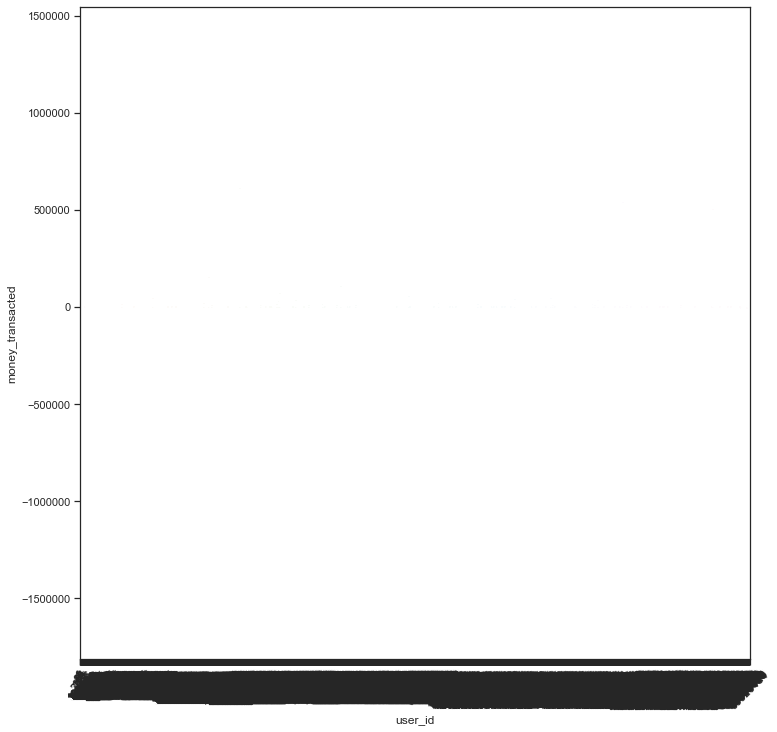

In [118]:
plt.figure(figsize=(12,12))
sns.barplot(x = df.user_id, y = 'money_transacted', data=df)
plt.xticks(rotation=45)
plt.show()

<html><i>The above plot doesnt depict much information</i></html>

In [119]:
df1 = data.groupby(['partner_id'])['money_transacted'].sum().reset_index()
#df.reset_index()
df1.sort_values('money_transacted', ascending = False)

,partner_id,money_transacted
14,118335,8.536415e+06
9,78890,4.210589e+05
17,157780,3.197400e+05
18,165669,3.063131e+05
6,55223,1.818000e+05
0,7889,1.703852e+05
12,102557,1.520399e+05
3,31556,1.289800e+05
16,149891,1.016220e+05
4,39445,7.610000e+04


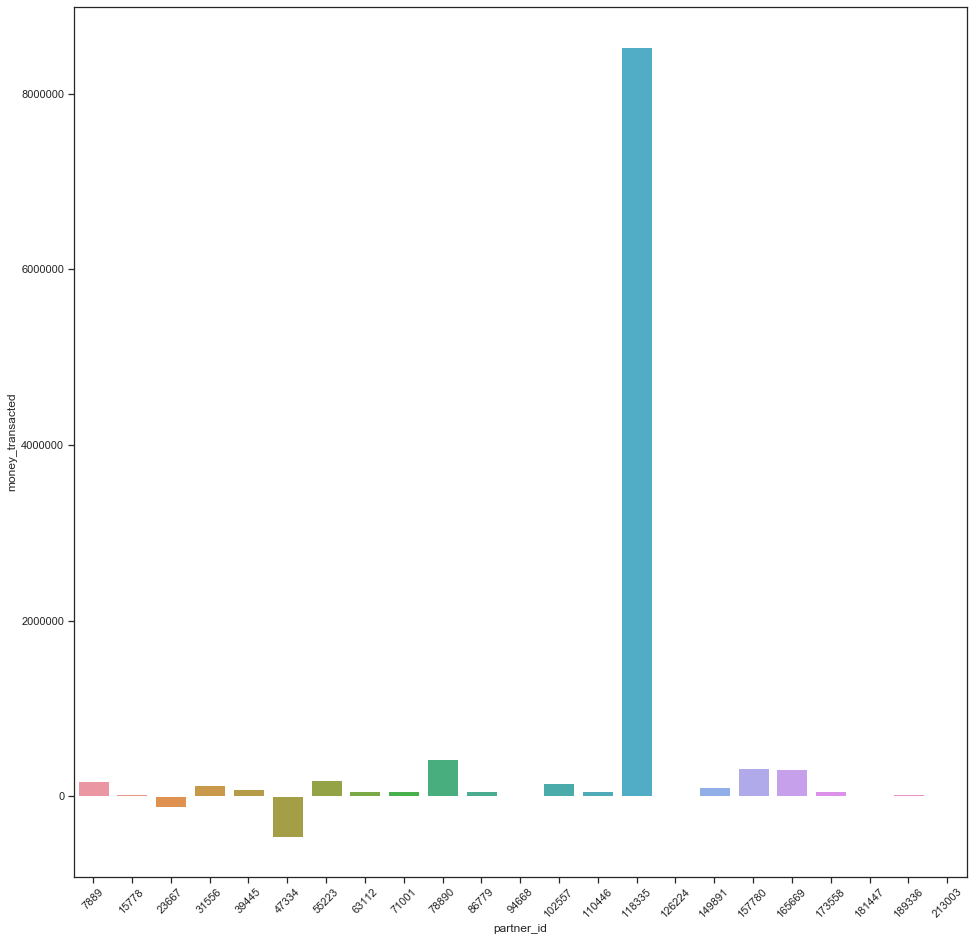

In [121]:
plt.figure(figsize=(16,16))
sns.barplot(x = df1.partner_id, y = 'money_transacted', data=df1)
plt.xticks(rotation=45)
plt.show()

<html><i><b>From the above plot, we can see that most of the high transactions were done by the Partner ID <span style=color:red>118335</span></b></i></html>

In [290]:
#Filtering by the partner Id and the fraudulent transactions gives the below results
data[(data.partner_id == 118335) & (data.is_fraud == 1)]

,user_id,payment_method,partner_id,partner_category,device_type,money_transacted,partner_pricing_category,is_fraud,Time
196,1695204,visa_master_credit_cards,118335,cat_1,other_pcs,40000.00,2,1,91913.0
571,7054336,visa_master_credit_cards,118335,cat_1,windows_pcs,6000.00,2,1,99688.0
1267,19829209,other_debit_cards,118335,cat_1,other_pcs,10000.00,0,1,26946.0
1420,19829209,other_debit_cards,118335,cat_1,other_pcs,60000.00,0,1,26943.0
3115,5134756,visa_master_credit_cards,118335,cat_1,other_pcs,10000.00,2,1,123353.0
3206,826281,visa_master_debit_cards,118335,cat_1,other_pcs,60000.00,2,1,112803.0
3427,826281,visa_master_debit_cards,118335,cat_1,other_pcs,59000.00,2,1,111897.0
3836,19280881,visa_master_debit_cards,118335,cat_1,other_pcs,100000.00,0,1,8381.0
4911,7306209,visa_master_credit_cards,118335,cat_1,other_pcs,10000.00,2,1,68722.0
5083,23794884,other_debit_cards,118335,cat_1,other_pcs,10000.00,0,1,29456.0


In [353]:
#Drop transaction intiation column
back_up_df = data.copy()
data.drop('transaction_initiation', axis=1, inplace=True)

In [354]:
data.columns

Index(['user_id', 'payment_method', 'partner_id', 'partner_category',
       'device_type', 'money_transacted', 'partner_pricing_category',
       'is_fraud', 'Time'],
      dtype='object')

In [355]:
col_to_be_converted = ['user_id', 'partner_id', 'partner_pricing_category', 'is_fraud']
data[col_to_be_converted] = data[col_to_be_converted].astype('category')
data.dtypes

user_id                     category
payment_method                object
partner_id                  category
partner_category              object
device_type                   object
money_transacted             float64
partner_pricing_category    category
is_fraud                    category
Time                         float64
dtype: object

In [356]:
num_cols = eda.fn_fetch_col_based_ontype(data,'int64','float64')
num_cols

['money_transacted', 'Time']

In [357]:
cat_cols = eda.fn_fetch_col_based_ontype(data,'object','category')
cat_cols.remove('is_fraud')
cat_cols

['user_id',
 'payment_method',
 'partner_id',
 'partner_category',
 'device_type',
 'partner_pricing_category']

In [358]:
X = data[num_cols + cat_cols]
y = data['is_fraud']
modelPrep = PrepModel()

In [359]:
X_train, X_valid, y_train, y_valid = modelPrep.fn_split_train_test(X,y)

Shape of X_Train is (61223, 8)
*************************************************************
Shape of y_train is (61223,)
*************************************************************
Shape of X_test is (15306, 8)
*************************************************************
Shape of y_test is (15306,)


In [360]:
#Intialize the pipeline
preprocessor = modelPrep.fn_init_pipeline(num_cols, cat_cols)


In [160]:
X_train.shape
y_train.shape

(61223,)

In [178]:
X_train.head()

,money_transacted,Time,user_id,payment_method,partner_id,partner_category,device_type,partner_pricing_category
32409,30.0,34051.0,6697744,e_wallet_payments,23667,cat_2,other_pcs,2
30555,-300.0,77284.0,53919649,sbi_atm_cum_debit_card,23667,cat_2,android_devices,4
43231,-0.5,52930.0,13205956,sbi_atm_cum_debit_card,47334,cat_1,android_devices,2
30026,70.0,104988.0,20839225,e_wallet_payments,31556,cat_2,other_pcs,2
22221,-0.4,113169.0,705600,sbi_atm_cum_debit_card,47334,cat_1,android_devices,2


<html><h2>Feature Importances</h2></html>

In [185]:
#Calculation features through Random Forest
%%time
clf_rfc_featureImp = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'))])
clf_rfc_featureImp.fit(X_train, y_train)


Wall time: 3.28 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trf',
                                                  Pipeline(steps=[('num_scaler',
                                                                   StandardScaler())]),
                                                  ['money_transacted', 'Time']),
                                                 ('cat_trf',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['user_id', 'payment_method',
                                                   'partner_id',
                                                   'partner_category',
                                                   'device_type',
                                                   'partner_pricing_category'])])),
                ('model',
                

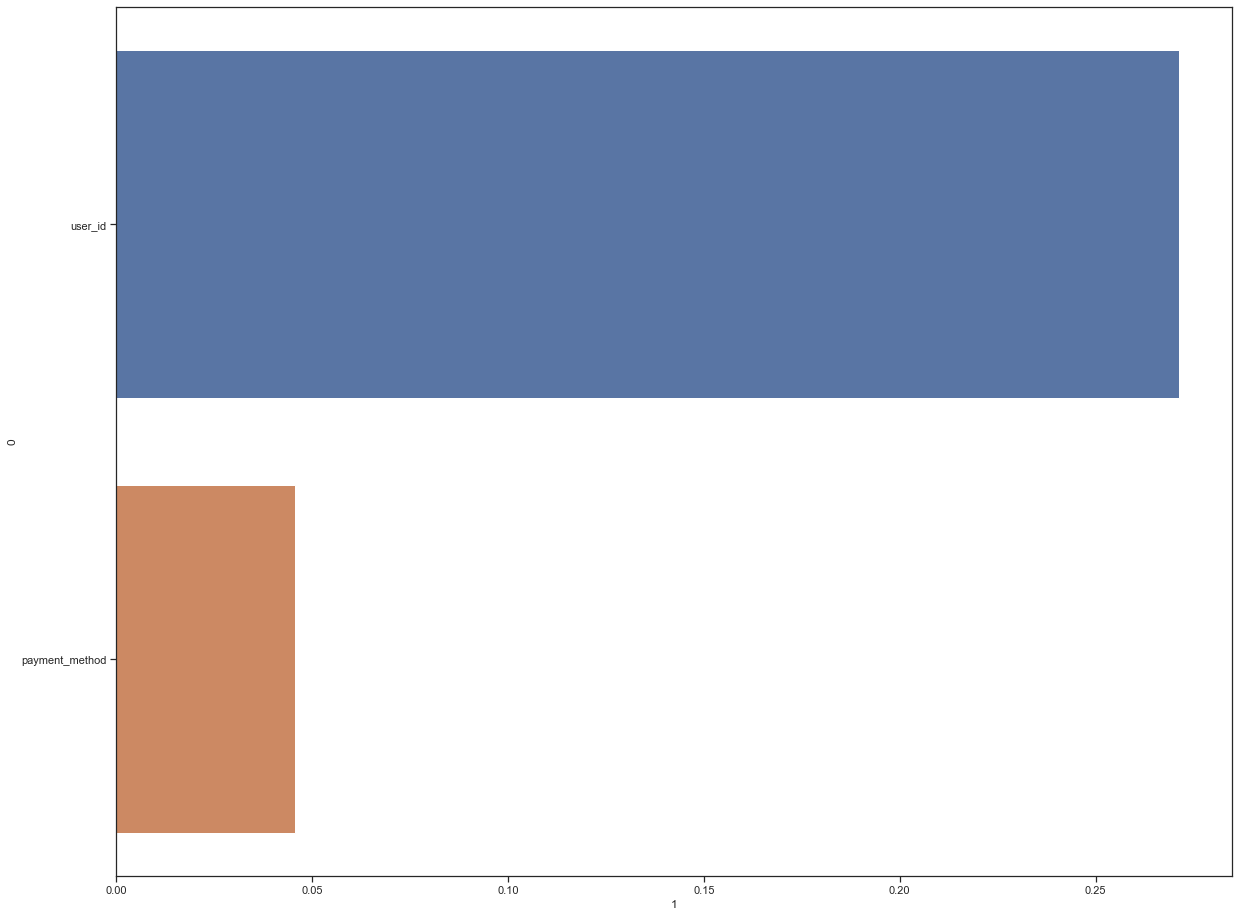

In [187]:
plt.figure(figsize=(20,16))
d = pd.DataFrame([data.columns[~data.columns.isin(['is_fraud'])],clf_rfc_featureImp.steps[1][1].feature_importances_]).T
d = d.sort_values([1],ascending=False)[0:10]
sns.barplot(d[1],d[0])

In [182]:
#Calculating features through Decision Trees
%%time
clf_dt_featureImp = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])
clf_dt_featureImp.fit(X_train, y_train)

Wall time: 270 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trf',
                                                  Pipeline(steps=[('num_scaler',
                                                                   StandardScaler())]),
                                                  ['money_transacted', 'Time']),
                                                 ('cat_trf',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['user_id', 'payment_method',
                                                   'partner_id',
                                                   'partner_category',
                                                   'device_type',
                                                   'partner_pricing_category'])])),
                ('model',
                

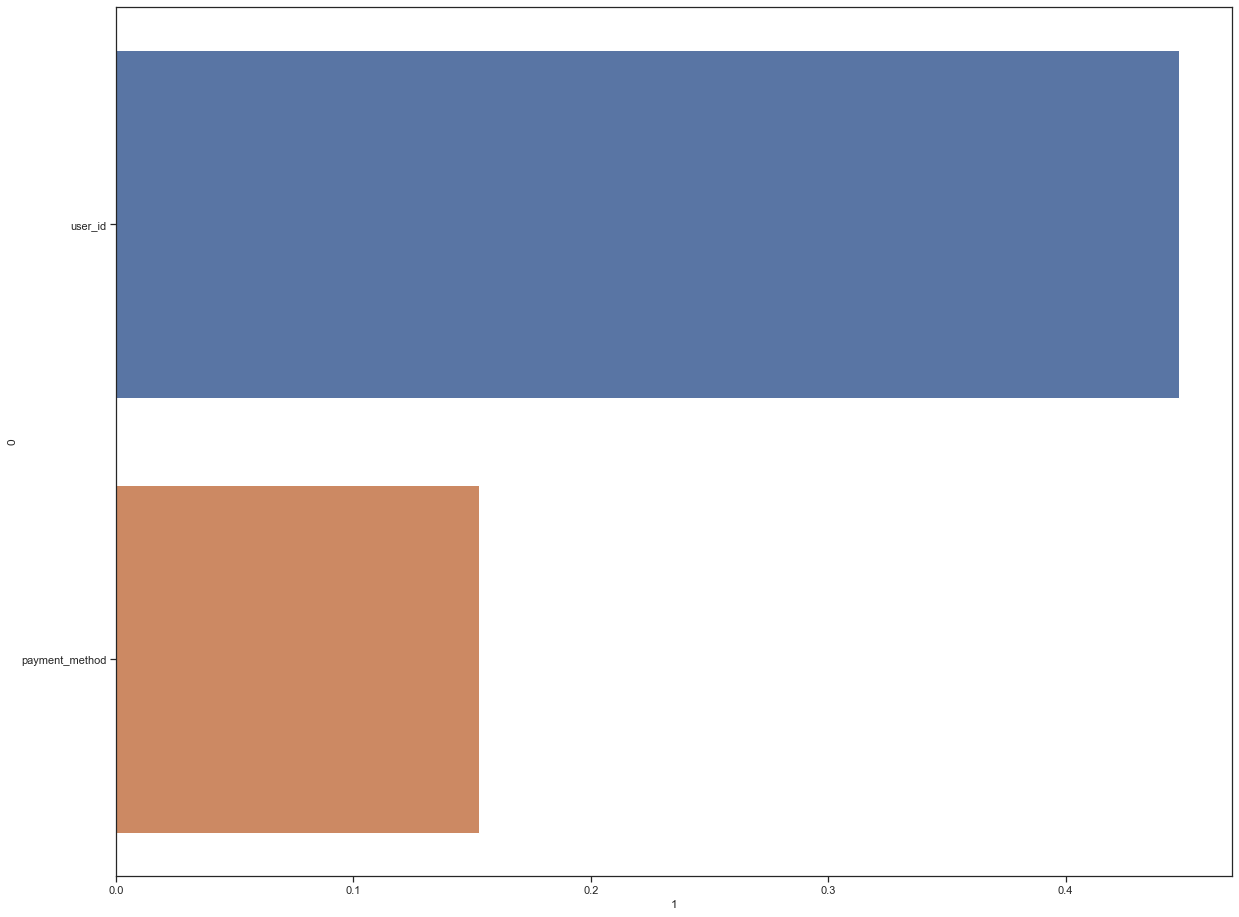

In [183]:
plt.figure(figsize=(20,16))
d1 = pd.DataFrame([data.columns[~data.columns.isin(['is_fraud'])],clf_dt_featureImp.steps[1][1].feature_importances_]).T
d1 = d1.sort_values([1],ascending=False)[0:10]
sns.barplot(d[1],d[0])

<html><h2>Model Building </h2></html>

In [192]:
eda.fn_set_up_metric_data()

<html><h3>Logistic Regression</h3></html>

In [412]:
%%time
clf_log_reg = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', LogisticRegression(random_state=42))])

logreg_param_grid = {"classifier__penalty" : ["l1", "l2","elasticnet"],                   
                     "classifier__class_weight": ['balanced']}

logreg_grid_bal = GridSearchCV(clf_log_reg, param_grid=logreg_param_grid, cv=5, n_jobs=-1, verbose=3, scoring = make_scorer(
                                    lambda yt,yp: f1_score(yt,yp,pos_label = 1)))
logreg_grid_bal.fit(X_train, y_train)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    6.6s finished


Wall time: 7.56 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_trf',
                                                                         Pipeline(steps=[('num_scaler',
                                                                                          StandardScaler())]),
                                                                         ['money_transacted',
                                                                          'Time']),
                                                                        ('cat_trf',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['user_id',
                                              

In [208]:
metric_data = eda.fn_set_up_metric_data()

In [209]:
eda.fn_compute_metrics(logreg_grid_bal, X_train, X_valid, y_train, y_valid,1,'Log Reg')

0.7014492753623188
0.6593406593406593


[[60999   103]
 [    0   121]]
[[15245    28]
 [    3    30]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61102
           1       0.54      1.00      0.70       121

    accuracy                           1.00     61223
   macro avg       0.77      1.00      0.85     61223
weighted avg       1.00      1.00      1.00     61223



In [210]:
metric_data

,Iteration No,Model Name,Method Type,Accuracy Score,F1 score,Recall Score,Precision Score
0,1,Log Reg,Train,0.998318,0.701449,1.000000,0.540179
1,1,Log Reg,Test,0.997975,0.659341,0.909091,0.517241


<html><h3>Decision Tree with stratified K-Fold Cross Validation</h3></html>

In [205]:
%%time
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(random_state=42))])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10],
                "classifier__class_weight": ['balanced']}

dt_grid_bal = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=kfold, n_jobs=-1, scoring = make_scorer(
                                    lambda yt,yp: f1_score(yt,yp,pos_label = 1)), verbose = 3)

dt_grid_bal.fit(X_train,y_train)
dt_grid_bal.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   46.4s finished


Wall time: 46.8 s


{'classifier__class_weight': 'balanced',
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 8,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 2}

In [211]:
eda.fn_compute_metrics(dt_grid_bal, X_train, X_valid, y_train, y_valid,2,'DT')

0.8832116788321168
0.8888888888888888


[[61070    32]
 [    0   121]]
[[15266     7]
 [    1    32]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61102
           1       0.79      1.00      0.88       121

    accuracy                           1.00     61223
   macro avg       0.90      1.00      0.94     61223
weighted avg       1.00      1.00      1.00     61223



In [212]:
metric_data

,Iteration No,Model Name,Method Type,Accuracy Score,F1 score,Recall Score,Precision Score
0,1,Log Reg,Train,0.998318,0.701449,1.000000,0.540179
1,1,Log Reg,Test,0.997975,0.659341,0.909091,0.517241
2,2,DT,Train,0.999477,0.883212,1.000000,0.790850
3,2,DT,Test,0.999477,0.888889,0.969697,0.820513


In [214]:
%%time
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)
clf_rfc = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier(random_state=42))])

rfc_param_grid = {"classifier__n_estimators" : [100, 150, 200],
                  "classifier__max_depth" : [5,8,10],
                  "classifier__max_features" : [3, 5, 7],
                  "classifier__min_samples_leaf" : [4, 6, 8, 10],
                  "classifier__class_weight": ['balanced']}

rfc_grid_bal = GridSearchCV(clf_rfc, param_grid=rfc_param_grid, cv=kfold, n_jobs=-1, verbose=3, scoring = make_scorer(
                                    lambda yt,yp: f1_score(yt,yp,pos_label = 1)))

rfc_grid_bal.fit(X_train,y_train)
rfc_grid_bal.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.6min finished


Wall time: 6min 40s


{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 10,
 'classifier__max_features': 3,
 'classifier__min_samples_leaf': 8,
 'classifier__n_estimators': 150}

In [215]:
eda.fn_compute_metrics(rfc_grid_bal, X_train, X_valid, y_train, y_valid,3,'RF')

0.006481794611655957
0.0062520933348219265


[[25854 35248]
 [    6   115]]
[[6377 8896]
 [   5   28]]
              precision    recall  f1-score   support

           0       1.00      0.42      0.59     61102
           1       0.00      0.95      0.01       121

    accuracy                           0.42     61223
   macro avg       0.50      0.69      0.30     61223
weighted avg       1.00      0.42      0.59     61223



In [216]:
metric_data

,Iteration No,Model Name,Method Type,Accuracy Score,F1 score,Recall Score,Precision Score
0,1,Log Reg,Train,0.998318,0.701449,1.000000,0.540179
1,1,Log Reg,Test,0.997975,0.659341,0.909091,0.517241
2,2,DT,Train,0.999477,0.883212,1.000000,0.790850
3,2,DT,Test,0.999477,0.888889,0.969697,0.820513
4,3,RF,Train,0.424171,0.006482,0.950413,0.003252
5,3,RF,Test,0.418463,0.006252,0.848485,0.003138


<html><h3>Smoothing Techniques</h3></html>

In [259]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)])

In [414]:
clf = Pipeline(steps=[('preprocessor', preprocessor)])



X_train_pp = pd.DataFrame(clf.fit_transform(X_train))
X_test_pp = pd.DataFrame(clf.transform(X_valid))

In [415]:
smote = RandomOverSampler(random_state=42)

#X_train_pp.head()

os_data_X,os_data_y=smote.fit_resample(X_train_pp, y_train)

os_data_X = pd.DataFrame(data=os_data_X)
os_data_y= pd.DataFrame(data=os_data_y,columns=['is_fraud'])

In [416]:
os_data_y.columns

Index(['is_fraud'], dtype='object')

In [417]:
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no frauds in oversampled data",len(os_data_y[os_data_y['is_fraud']==1]))
print("Number of frauds",len(os_data_y[os_data_y['is_fraud']==0]))
#print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='no'])/len(os_data_X))
#print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['y']=='yes'])/len(os_data_X))

length of oversampled data is  122204
Number of no frauds in oversampled data 61102
Number of frauds 61102


<html><h3>XG Boost with Stratified K-Fold and Hyper Parameter <i>scale_pos_weight</i> for imbalanced data</h3></html>

In [279]:
%%time
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_xgboost = Pipeline(steps=[('preprocessor', preprocessor),('classifier', XGBClassifier())])

xgb_param_grid = {"classifier__n_estimators" : [10, 50, 100, 500],
                  "classifier__learning_rate" : [0.05, 0.1, 0.5, 1],
                  "classifier__early_stopping_rounds" : [5],
                  "classifier__scale_pos_weight" : [2,3,4,5]
                 }

xgb_grid_bal = GridSearchCV(clf_xgboost, param_grid=xgb_param_grid, cv=kfold, n_jobs=-1, scoring = make_scorer(
                                    lambda yt,yp: f1_score(yt,yp,pos_label = 1)), verbose = 3)

xgb_grid_bal.fit(X_train,y_train)
xgb_grid_bal.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 15.4min finished


[15:26:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 15min 24s


{'classifier__early_stopping_rounds': 5,
 'classifier__learning_rate': 1,
 'classifier__n_estimators': 10,
 'classifier__scale_pos_weight': 4}

In [280]:
eda.fn_compute_metrics(xgb_grid_bal, X_train, X_valid, y_train, y_valid,4,'XGB')

0.9877551020408163
0.9117647058823529


[[61099     3]
 [    0   121]]
[[15269     4]
 [    2    31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61102
           1       0.98      1.00      0.99       121

    accuracy                           1.00     61223
   macro avg       0.99      1.00      0.99     61223
weighted avg       1.00      1.00      1.00     61223



In [281]:
metric_data

,Iteration No,Model Name,Method Type,Accuracy Score,F1 score,Recall Score,Precision Score
0,1,Log Reg,Train,0.998318,0.701449,1.000000,0.540179
1,1,Log Reg,Test,0.997975,0.659341,0.909091,0.517241
2,2,DT,Train,0.999477,0.883212,1.000000,0.790850
3,2,DT,Test,0.999477,0.888889,0.969697,0.820513
4,3,RF,Train,0.424171,0.006482,0.950413,0.003252
5,3,RF,Test,0.418463,0.006252,0.848485,0.003138
6,4,XGB,Train,0.999951,0.987755,1.000000,0.975806
7,4,XGB,Test,0.999608,0.911765,0.939394,0.885714


<html><h3>LGBM Boost with Stratified K-Fold and Hyper Parameter <i>scale_pos_weight</i> for imbalanced data</h3></html>

In [292]:
%%time
clf_lgbm = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LGBMClassifier())])

lgbm_param_grid = {"classifier__n_estimators" : [10, 50, 100, 500],
                  "classifier__learning_rate" : [0.05, 0.1, 0.5, 1],
                  "classifier__scale_pos_weight" : [2,3,4,5]
                 }

lgbm_grid_bal = GridSearchCV(clf_lgbm, param_grid=lgbm_param_grid, cv=5, n_jobs=-1, scoring = make_scorer(
                                    lambda yt,yp: f1_score(yt,yp,pos_label = 1)), verbose = 3)

lgbm_grid_bal.fit(X_train,y_train)
lgbm_grid_bal.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  3.9min finished


Wall time: 3min 55s


{'classifier__learning_rate': 0.05,
 'classifier__n_estimators': 50,
 'classifier__scale_pos_weight': 3}

In [293]:
eda.fn_compute_metrics(lgbm_grid_bal, X_train, X_valid, y_train, y_valid,5,'LGBM')

0.91699604743083
0.8285714285714285


[[61086    16]
 [    5   116]]
[[15265     8]
 [    4    29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61102
           1       0.88      0.96      0.92       121

    accuracy                           1.00     61223
   macro avg       0.94      0.98      0.96     61223
weighted avg       1.00      1.00      1.00     61223



In [294]:
metric_data

,Iteration No,Model Name,Method Type,Accuracy Score,F1 score,Recall Score,Precision Score
0,1,Log Reg,Train,0.998318,0.701449,1.000000,0.540179
1,1,Log Reg,Test,0.997975,0.659341,0.909091,0.517241
2,2,DT,Train,0.999477,0.883212,1.000000,0.790850
3,2,DT,Test,0.999477,0.888889,0.969697,0.820513
4,3,RF,Train,0.424171,0.006482,0.950413,0.003252
5,3,RF,Test,0.418463,0.006252,0.848485,0.003138
6,4,XGB,Train,0.999951,0.987755,1.000000,0.975806
7,4,XGB,Test,0.999608,0.911765,0.939394,0.885714
8,5,LGBM,Train,0.999657,0.916996,0.958678,0.878788
9,5,LGBM,Test,0.999216,0.828571,0.878788,0.783784


In [361]:
%%time
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf_xgboost1 = Pipeline(steps=[('preprocessor', preprocessor),('classifier', XGBClassifier())])

xgb_param_grid = {"classifier__n_estimators" : [10, 50, 100, 500],
                  "classifier__learning_rate" : [0.05, 0.1, 0.5, 1],
                  "classifier__early_stopping_rounds" : [5],
                  "classifier__scale_pos_weight" : [2,3,4,5]
                 }

xgb_grid_bal1 = GridSearchCV(clf_xgboost1, param_grid=xgb_param_grid, cv=kfold, n_jobs=-1, scoring = make_scorer(
                                    lambda yt,yp: f1_score(yt,yp,pos_label = 1)), verbose = 3)

xgb_grid_bal1.fit(X_train,y_train)
xgb_grid_bal1.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed: 14.8min finished


[17:34:01] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Wall time: 14min 52s


{'classifier__early_stopping_rounds': 5,
 'classifier__learning_rate': 1,
 'classifier__n_estimators': 50,
 'classifier__scale_pos_weight': 2}

In [362]:
eda.fn_compute_metrics(xgb_grid_bal1, X_train, X_valid, y_train, y_valid,6,'XGB with K-fold')

0.9958847736625513
0.9117647058823529


[[61101     1]
 [    0   121]]
[[15269     4]
 [    2    31]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61102
           1       0.99      1.00      1.00       121

    accuracy                           1.00     61223
   macro avg       1.00      1.00      1.00     61223
weighted avg       1.00      1.00      1.00     61223



In [419]:
metric_data

,Iteration No,Model Name,Method Type,Accuracy Score,F1 score,Recall Score,Precision Score
0,1,Log Reg,Train,0.998318,0.701449,1.000000,0.540179
1,1,Log Reg,Test,0.997975,0.659341,0.909091,0.517241
2,2,DT,Train,0.999477,0.883212,1.000000,0.790850
3,2,DT,Test,0.999477,0.888889,0.969697,0.820513
4,3,RF,Train,0.424171,0.006482,0.950413,0.003252
5,3,RF,Test,0.418463,0.006252,0.848485,0.003138
6,4,XGB,Train,0.999951,0.987755,1.000000,0.975806
7,4,XGB,Test,0.999608,0.911765,0.939394,0.885714
8,5,LGBM,Train,0.999657,0.916996,0.958678,0.878788
9,5,LGBM,Test,0.999216,0.828571,0.878788,0.783784


<html><h2>SUBMISSIONS</h2></html>

In [401]:
test_data = pd.read_csv("./datasets/test_data-1599717650029.csv")

In [402]:
test_data['transaction_initiation'] = pd.to_datetime(test_data['transaction_initiation'], format='%Y-%m-%d %H:%M:%S')
test_data['transaction_initiation'] = test_data['transaction_initiation'].dt.strftime('%Y-%m-%d %H:%M:%S')
test_data['transaction_initiation'] = pd.to_datetime(test_data['transaction_initiation'], format='%Y-%m-%d %H:%M:%S')

In [403]:
test_data.columns

Index(['transaction_number', 'user_id', 'payment_method', 'partner_id',
       'partner_category', 'country', 'device_type', 'money_transacted',
       'transaction_initiation', 'partner_pricing_category'],
      dtype='object')

In [404]:
test_data_df = test_data.copy()
test_data.drop(['country','transaction_number'], axis=1, inplace=True)

In [405]:
test_data['Time'] = test_data['transaction_initiation'].apply(lambda x: fn_calc_elapsed_time(x))

In [406]:
test_data.head()

,user_id,payment_method,partner_id,partner_category,device_type,money_transacted,transaction_initiation,partner_pricing_category,Time
0,3802500,visa_master_debit_cards,118335,cat_1,other_pcs,200.0,2016-12-28 14:44:37,2,61648.0
1,200704,e_wallet_payments,23667,cat_2,other_pcs,20.0,2016-12-14 17:49:48,2,41673.0
2,25150225,sbi_atm_cum_debit_card,47334,cat_1,android_devices,-100.0,2017-01-21 10:18:11,2,95941.0
3,21827584,visa_master_credit_cards,78890,cat_2,other_pcs,200.0,2017-01-16 13:25:10,1,88928.0
4,576081,e_wallet_payments,23667,cat_2,other_pcs,100.0,2017-02-09 12:47:28,2,123451.0


In [407]:
test_data.drop('transaction_initiation', axis=1, inplace=True)

In [408]:
test_pred = xgb_grid_bal1.predict(test_data)

In [409]:
test_data.columns

Index(['user_id', 'payment_method', 'partner_id', 'partner_category',
       'device_type', 'money_transacted', 'partner_pricing_category', 'Time'],
      dtype='object')

In [410]:
submissions_df = pd.DataFrame({'transaction_number': test_data_df.transaction_number, 'is_fraud': test_pred})
submissions_df.to_csv("./datasets/test_predictions.csv", index=None)
submissions_df.head()

,transaction_number,is_fraud
0,857050141038272,0
1,4400462872603,0
2,1207915598569499,0
3,2009725616777536,0
4,2319205210274863,0


In [411]:
metric_data.to_csv("./datasets/ModelMetrics2.csv")